# TODO: Import the required libraries

In [1]:
# TODO
import os
import numpy as np
import tensorflow as tf
import random
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Adding random seed

In [2]:
# Set environment variables
os.environ['PYTHONHASHSEED'] = str(25)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Set seed values
np.random.seed(25)
tf.random.set_seed(25)
random.seed(25)

# TODO: Read and Preprocess the dataset

In [3]:
path = './alice.txt'
text = ""

# TODO: Load and preprocess the text
with open(path, 'r', encoding='utf-8') as file:
    text = file.read().lower()
    
text = re.sub(r'[^\w\s]', '', text)


In [4]:
print(len(text))

140269


# TODO: Using tokenizers

In [5]:
# TODO: Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
total_words = len(tokenizer.word_index) + 1

In [6]:
print(total_words)

2751


# TODO: Feature Engineering

In [7]:
# TODO: Create input sequences
input_sequences = []
for line in text.split('\n'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


# TODO: Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')


In [8]:
print(len(input_sequences))

23693


# TODO: Storing features and labels

In [9]:
# TODO: Create predictors and labels
predictors, labels = input_sequences[:,:-1], input_sequences[:,-1]
labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# TODO: Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(predictors, labels, test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(18954, 15) (18954, 2751)
(4739, 15) (4739, 2751)


# TODO: Building our model

In [10]:
# TODO: Build your model
model = Sequential([
    Embedding(total_words, 100, input_length=max_sequence_len - 1),
    LSTM(150),
    Dropout(0.4),
    Dense(total_words, activation='softmax')
])
# model = Sequential([
#     Embedding(total_words, 100, input_length=max_sequence_len - 1),
#     Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.01))),
#     Dropout(0.5),
#     LayerNormalization(),
#     LSTM(100, kernel_regularizer=l2(0.01)),
#     Dropout(0.5),
#     Dense(total_words, activation='softmax')
# ])
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           275100    
                                                                 
 lstm (LSTM)                 (None, 150)               150600    
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense (Dense)               (None, 2751)              415401    
                                                                 
Total params: 841101 (3.21 MB)
Trainable params: 841101 (3.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# TODO: Model training

In [11]:
# TODO: Train your model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
593/593 [==============================] - 6s 10ms/step - loss: 6.1675 - accuracy: 0.0636 - val_loss: 6.0303 - val_accuracy: 0.0585
Epoch 2/20
593/593 [==============================] - 6s 10ms/step - loss: 5.8440 - accuracy: 0.0677 - val_loss: 5.9594 - val_accuracy: 0.0679
Epoch 3/20
593/593 [==============================] - 6s 10ms/step - loss: 5.6346 - accuracy: 0.0852 - val_loss: 5.8281 - val_accuracy: 0.0853
Epoch 4/20
593/593 [==============================] - 6s 11ms/step - loss: 5.4180 - accuracy: 0.1018 - val_loss: 5.7447 - val_accuracy: 0.1009
Epoch 5/20
593/593 [==============================] - 7s 11ms/step - loss: 5.2007 - accuracy: 0.1179 - val_loss: 5.6673 - val_accuracy: 0.1148
Epoch 6/20
593/593 [==============================] - 7s 12ms/step - loss: 4.9866 - accuracy: 0.1344 - val_loss: 5.6338 - val_accuracy: 0.1226
Epoch 7/20
593/593 [==============================] - 8s 13ms/step - loss: 4.7993 - accuracy: 0.1503 - val_loss: 5.6223 - val_accuracy: 0.1310

# TODO: Visualising the Training and Validation Accuracies and Losses against the number of Epochs

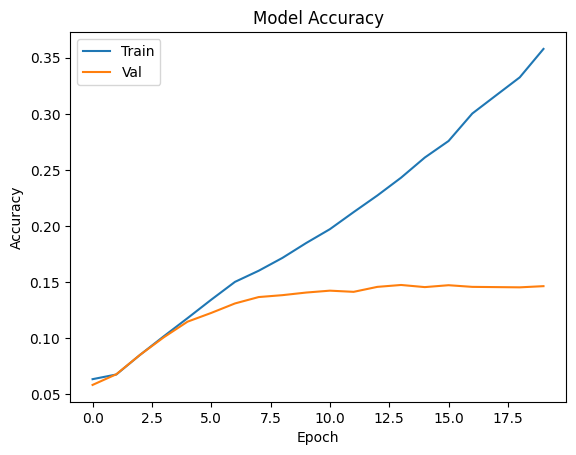

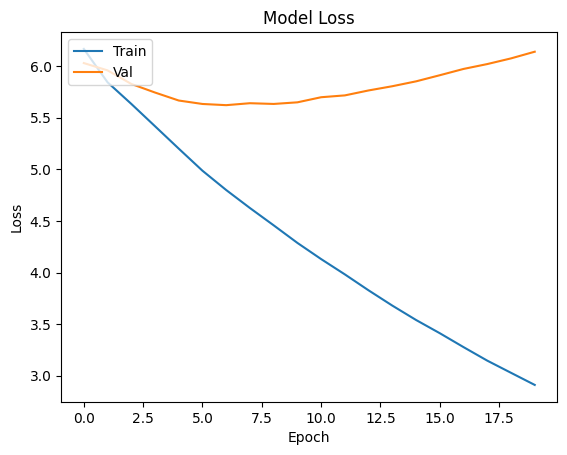

In [12]:
# TODO: Plotting the training and validation loss and accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# TODO: Generate text

In [32]:
# TODO: Function to generate text
def generate_text(seed_text, next_words, model, max_sequence_len, temperature):
    # TODO
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)[0]
        predicted = np.log(predicted + 1e-10) / temperature  
        predicted = np.exp(predicted) / np.sum(np.exp(predicted))
        next_index = np.random.choice(range(len(predicted)), p=predicted)
        next_word = tokenizer.index_word[next_index]
        seed_text += " " + next_word
    return seed_text

# Generate text
seed_text = "Forest is"
next_words = 10
temperature = 0.05
generated_text = generate_text(seed_text, next_words, model, max_sequence_len, temperature)
print(generated_text)

Forest is a little thing said the king and the hatter went
